## Nome: Fabio Grassiotto
## RA: 890441
## Disciplina: IA369Y, 2º S 2017
## T3 - Análise e Síntese de Emoções em Conteúdo Multimídia
## Atividade 5 - Classificador de emoções para base de fotos rotulada.

## 1. Objetivo

O objetivo desta atividade é implementar um classificador de emoções utilizando marcos faciais para uma base de fotos rotulada. A base contém fotos do rosto de uma atriz e um arquivo csv com o nome do arquivo, rótulo emocional e 56 pares de coordenadas no formato (x;y) mapeando os marcos faciais em cada uma das fotos.

Para executar a classificação, 80% da base será utilizada como conjunto de treinamento enquanto que os 20% restantes serão classificados utilizando a biblioteca scikit-learn. A acurácia do classificador será relatada em comparação com os rótulos fornecidos.

## 2. Leitura da base de dados

O primeiro passo consistirá na leitura do corpus fornecido. Analisando o arquivo CSV, notei que as colunas de índice 1-8 não contém informações relevantes para a classificação e portanto poderiam ser descartadas.
O carrregamento dos dados foi realizada utilizando a biblioteca Pandas, excluindo os dados desnecessários, conforme o script a seguir.


In [1]:
import pandas as pd
import numpy as np

def read_csv():
    "Leitura das colunas: nome do arquivo, rótulo, 56 colunas de coordenadas."
    all_cols = list(range(0,65))
    remove_cols = set(range(2,9))
    cols = [col for col in all_cols if col not in remove_cols]
    return pd.read_csv('Faces_Disciplina\imagedb_CH_disciplina.csv', header=None, usecols=cols)

df = read_csv()

pd.set_option('display.max_rows', 3)
pd.set_option('display.max_columns', 6)

df

,0,1,9,...,62,63,64
0,Em9_Fala3_0204_640x480.png,admiration,(303.5;319.0),...,(344.0;338.0),(363.5;325.5),(363.5;333.0)
...,...,...,...,...,...,...,...
896,Em16_Fala3_0180_640x480.png,shame,(285.5;328.0),...,(315.0;332.5),(328.0;328.5),(328.0;331.0)


## 3. Divisão da base de dados

Após a leitura do corpus, a base de dados foi dividida em dois conjuntos de forma aleatória:

- 80% dos dados serão utilizados como dados de treinamento do classificador.
- 20% dos dados serão utilizados como dados de validação do classificador.

O racional para se dividir a base desta forma se justifica pelo tamanho da base, que é razoavelmentr pequena (< 1000 amostras). Ao se utilizar uma base de treinamento maior que a de validação, busca-se evitar variância nos parâmetros de classificação.

Para se executar a divisão das bases, foi executado o script a seguir.

In [7]:
msk = np.random.rand(len(df)) < 0.8
training = df[msk]
testing = df[~msk]

pd.set_option('display.max_rows', 5)
training

,0,1,9,...,62,63,64
1,Em9_Fala1_0220_640x480.png,admiration,(317.5;328.5),...,(344.0;339.5),(354.0;323.5),(355.0;336.5)
2,Em9_Fala3_0147_640x480.png,admiration,(293.5;309.5),...,(328.5;330.0),(351.5;315.0),(351.5;325.5)
...,...,...,...,...,...,...,...
894,Em16_Fala2_0375_640x480.png,shame,(302.0;329.5),...,(337.5;344.0),(357.0;332.5),(357.0;342.0)
895,Em16_Fala1_0061_640x480.png,shame,(307.5;329.5),...,(338.5;332.0),(349.5;327.5),(350.0;331.0)


In [8]:
testing

,0,1,9,...,62,63,64
0,Em9_Fala3_0204_640x480.png,admiration,(303.5;319.0),...,(344.0;338.0),(363.5;325.5),(363.5;333.0)
3,Em9_Fala1_0142_640x480.png,admiration,(298.0;297.5),...,(339.0;319.5),(355.5;296.5),(357.0;319.5)
...,...,...,...,...,...,...,...
886,Em16_Fala2_0154_640x480.png,shame,(306.5;346.5),...,(337.5;355.0),(357.5;346.0),(353.0;354.0)
896,Em16_Fala3_0180_640x480.png,shame,(285.5;328.0),...,(315.0;332.5),(328.0;328.5),(328.0;331.0)


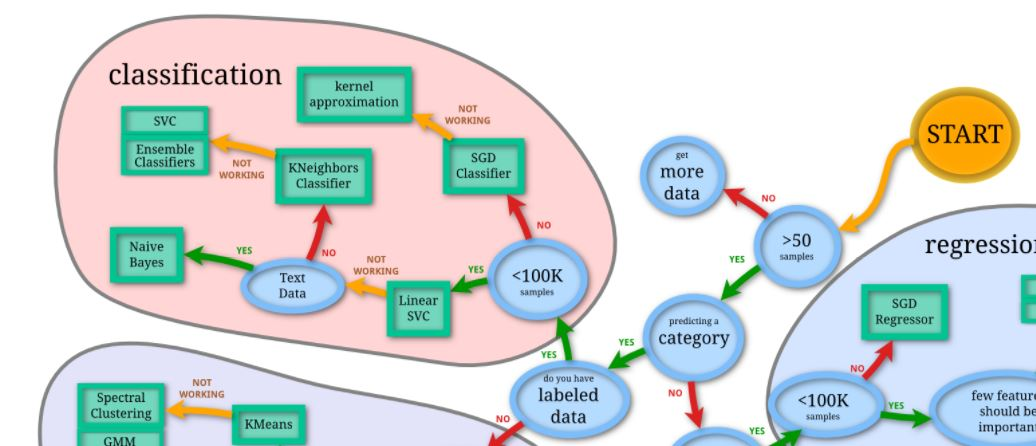

In [1]:
from IPython.display import Image, display
display(Image(filename='sklearn-algos.jpg', embed=True))

## Referências

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.